In [33]:
from PIL import Image
import numpy as np
import torch
import os
import sys
import io
import matplotlib.pyplot as plt
import matplotlib
from torch_geometric.data import DataLoader, Data
from models.modified_edgecnn_regression import Net
from tqdm.notebook import tqdm
from copy import deepcopy

In [34]:
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [35]:
def preprocess_validation(valid):
    x = valid[:, :10]
    y = valid[:, 10:]

    x_seq_number = np.expand_dims(np.arange(1, 11), axis=(0, 1, 2))
    y_seq_number = np.expand_dims(np.arange(11, 21), axis=(0, 1, 2))
    x_seq_number = np.repeat(x_seq_number, x.shape[2], axis=-1).reshape(1, 10, -1, 1)
    y_seq_number = np.repeat(y_seq_number, x.shape[2], axis=-1).reshape(1, 10, -1, 1)
    x_seq_number = np.tile(x_seq_number, (x.shape[0], 1, 1, 1))
    y_seq_number = np.tile(y_seq_number, (y.shape[0], 1, 1, 1))

    x = np.concatenate([x_seq_number, x, np.zeros([x.shape[0], x.shape[1], x.shape[2], 1])], axis=-1)
    y = np.concatenate([y_seq_number, y, np.zeros([y.shape[0], y.shape[1], y.shape[2], 1])], axis=-1)

    x = x.reshape(x.shape[0], x.shape[1] * y.shape[2], x.shape[3])
    y = y.reshape(x.shape[0], y.shape[1] * y.shape[2], y.shape[3])

    x = torch.tensor(x).float()
    y = torch.tensor(y).float()

    return [Data(x=i, y=j) for i, j in zip(x, y)]

In [36]:
def point_to_image(input):
    input = input.reshape([-1, 10, 128, 3])
    input = np.ceil(input).astype(np.uint8)
    im = np.zeros(shape=(input.shape[0], 10, 64, 64))
    for j in range(10):
        for k in range(128):
            indices = [np.arange(input.shape[0]), j, input[:, j, k, 0], input[:, j, k, 1]]
            im[indices] = 255
    im = np.swapaxes(im.astype(np.uint8), 1, 2)

    im = np.reshape(im, (input.shape[0], 64, -1))

    for j in range(1, 10):
        im[:, :, j * 64] = 255
    return [Image.fromarray(i, 'L') for i in im]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


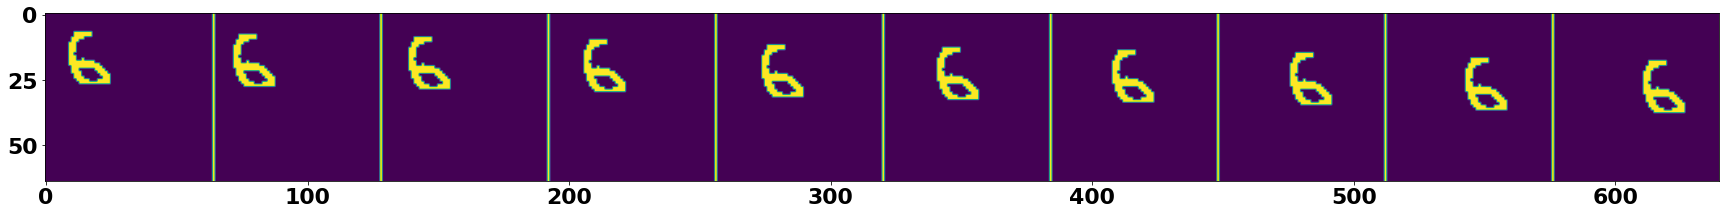

In [37]:
m = []
for data in test_loader:
    m = m + point_to_image(data.x[:, 1:].numpy())
fig = plt.figure(figsize=(30,10))
plt.imshow(m[0])

In [38]:
def plot_seq(index):
    fig = plt.figure(figsize=(30,10))
    
    ax_orig = fig.add_subplot(311)
    ax_true = fig.add_subplot(312)
    ax_pred = fig.add_subplot(313)
    
    
    ax_orig.imshow(context_list[index])
    ax_orig.axis('off')
    ax_orig.set_title('Input to the model')
    
    ax_true.imshow(ground_truth_list[index])
    ax_true.axis('off')
    ax_true.set_title('Ground Truth')
    
    ax_pred.imshow(prediction_list[index])
    ax_pred.axis('off')
    ax_pred.set_title('Predicted sequence')
    

# Model and Dataset loading

In [39]:
BATCH_SIZE = 5
device = torch.device('cuda')

model = Net(3).to(device)
model.load_state_dict(torch.load("temporal_regression_mmnist_decoder_step/model.pth"))
model.eval()

test_dataset = np.load('test-1mnist-64-128point-20step.npy')
test_dataset = preprocess_validation(test_dataset)
test_loader = DataLoader(
    test_dataset[:10], batch_size=BATCH_SIZE, shuffle=False)

# Prediction

In [40]:
example_dir = os.path.join('temporal_regression_mmnist', 'test-examples')
if not os.path.exists(example_dir):
    os.makedirs(example_dir)

context_list = []
ground_truth_list = []
prediction_list = []
for i, data in enumerate(tqdm(test_loader,desc="Calculating the sequences")):
#     print(data)
    data.to(device)
    curr_dir = os.path.join(example_dir, '%04d'%(i+1))
    if not os.path.exists(curr_dir):
        os.makedirs(curr_dir)
    labels = data.y[:, 1:].float()
    with torch.no_grad():
        seq = []
        input = deepcopy(data)
        for i in range(10):
            out = model(input).reshape(-1, 1, 128 * 3)
            seq.append(out)
            input.x[:, 1:] = torch.cat([input.x[:, 1:].reshape([-1, 10, 128*3])[:, 1:],
                                        out], dim=1).view(-1, 3)
        predictions = torch.cat(seq, dim=1).view(-1, 3)
    
    pc_context = data.x[:, 1:].cpu().numpy()
    pc_ground_truth = data.y[:, 1:].cpu().numpy()
    pc_prediction = predictions.cpu().numpy()
    
    pc_prediction = np.clip(pc_prediction, a_min=0, a_max=64 - 1)
    
    
    
    
    
    context_list = context_list + point_to_image(pc_context)
    ground_truth_list = ground_truth_list + point_to_image(pc_ground_truth)
    prediction_list = prediction_list + point_to_image(pc_prediction)
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [41]:
prediction_list

[<PIL.Image.Image image mode=L size=640x64 at 0x7FB6686BDF10>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB6686BD9D0>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB6686BDF50>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB6686BD350>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB6686BD610>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB66AB05850>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB66AB05A50>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB66AB05BD0>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB66AB05B90>,
 <PIL.Image.Image image mode=L size=640x64 at 0x7FB66AB05D50>]

# Visualization

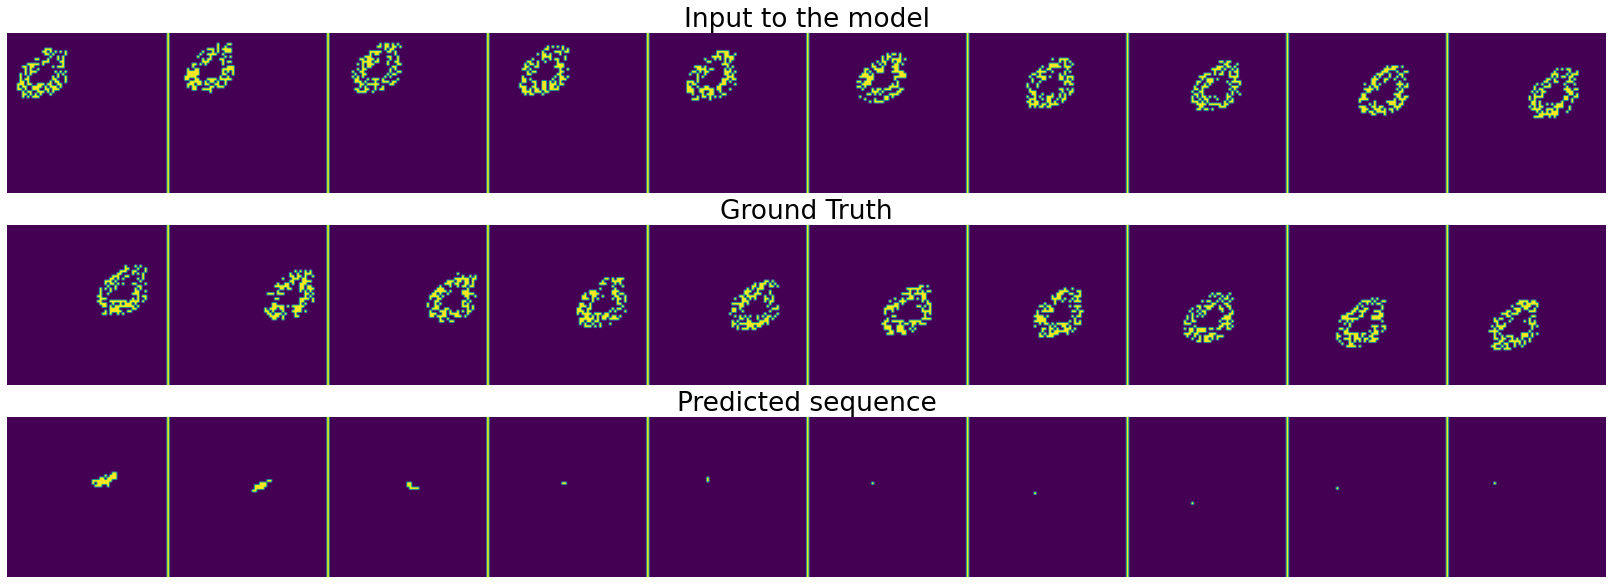

In [53]:
plot_seq(np.random.randint(len(prediction_list)))